Master 2 MVA - Computational Statistics
TP2 : Expectation-Maximisation algorithm – Importance sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns
import pandas as pd

Exercise 1 : Discrete distributions

In [2]:
#Question 2 (Custom sampling function)
def sample(p,x,N):
    c = p.cumsum() 
    u = np.random.rand(N,1)
    i = np.argmax(u<c,axis=1)
    return x[i]

In [81]:
def compare_empirical_theoretical_distribution(samples,x,p) :
    # Create a histogram of the experimental distribution
    hist, bin_edges = np.histogram(samples, bins=x.tolist()+[np.inf])


    hist = hist / samples.size #To obtain a density


    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)

    # Plot the histogram
    plt.bar(x, hist, width=0.5, align='center')
    plt.xlabel('X')
    plt.ylabel('Normalized frequency')
    plt.title('Empirical distribution')

    plt.xticks(x)  # Set x-axis ticks to the unique values


    plt.subplot(1, 2, 2)
    plt.bar(x, p, width=0.5, align='center', color='orange')
    plt.xlabel('X')
    plt.ylabel('Exact Probabilities')
    plt.title('Theoretical Distribution')
    plt.xticks(x)  # Set x-axis ticks to the unique values


    plt.tight_layout()  # Ensures proper spacing between subplots


    plt.show()

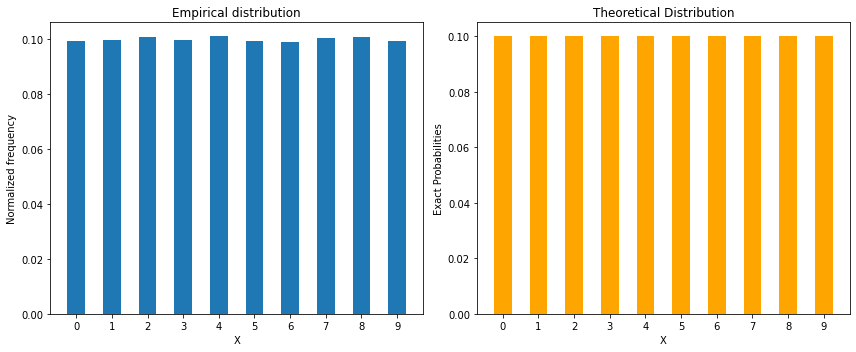

In [87]:
np.random.seed(1)
#We first try with the uniform distribution
n = 10
p = np.ones(n) * 1/n
x = np.arange(n)
samples = sample(p,x,100000)
compare_empirical_theoretical_distribution(samples,x,p)

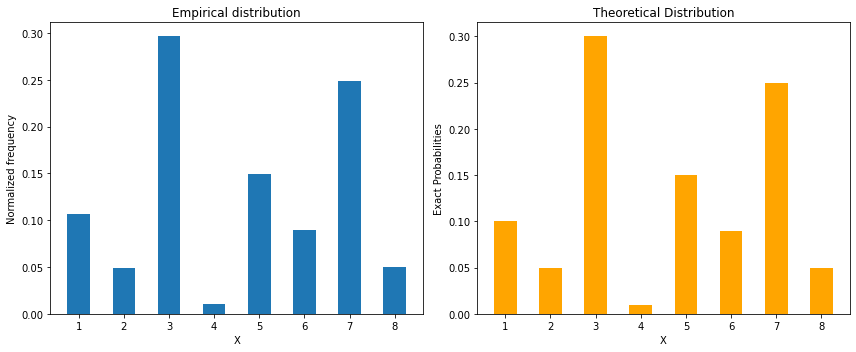

In [88]:
np.random.seed(1)
#We try with a more original distribution
p = np.array([0.1,0.05,0.3,0.01,0.15,0.09,0.25,0.05])
x = np.array([1,2,3,4,5,6,7,8])
samples = sample(p,x,10000)
compare_empirical_theoretical_distribution(samples,x,p)

Exercise 2 : Gaussian mixture model and the EM algorithm

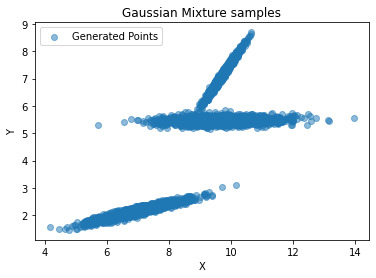

In [624]:
#Question 2

np.random.seed(4)
#Sample a set of observation according to a Gaussian mixture law when d = 2
d = 2

#We choose p and alpha randomly
#max_cluster = 3
#p = np.random.randint(max_cluster)+1
p=3
alpha_exact = np.ones(p) / p #balanced clusters
# alpha_exact = np.random.rand(p)
# alpha_exact /= np.sum(alpha_exact)


mu_max = 10
#mu can take values in [0,mu_max]^2


#For each cluster, we generate randomly the parameters of each gaussian distribution
mu_exact = np.random.rand(p,d)*mu_max

#Sigma_exact = np.array([np.eye(d)] * p)
Sigma_exact = np.zeros((p,d,d))
for k in range(p):
    V = np.random.rand(d,1)
    sigma_k = (V @ V.T) + 0.01
    #To be sure to obtain a symmetric definite positive matrix for the covariance matrix
    Sigma_exact[k] = sigma_k

#Number of samples
n = 5000

#For each sample, we sample alpha with the algorithm of the exercise 1
alpha_i = sample(alpha_exact,np.arange(p),n)



samples = []

# Generate samples for each mean-covariance pair
for mean, cov in zip(mu_exact[alpha_i], Sigma_exact[alpha_i]):
    mvn = multivariate_normal(mean=mean, cov=cov)
    point = mvn.rvs()
    samples.append(point)

x_samples, y_samples = zip(*samples)


fig, ax = plt.subplots()

ax.scatter(x_samples, y_samples, label='Generated Points', marker='o', alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Gaussian Mixture samples')
ax.legend()


# Show the plot
plt.show()


In [629]:
#Question 3 - Implementation of the EM algorithm

def EM(d,p,n,x,epsilon=0.001):

    #Initialization of the parameters alpha, mu and sigma for each cluster

    alpha = np.random.rand(p)
    alpha /= np.sum(alpha)

    #We take the mean of the samples
    mean_samples = np.mean(x,axis=0)

    
    #For each cluster, we generate randomly the parameters of each gaussian distribution
    #based on the mean of the samples
    mu = mean_samples + (np.random.rand(p,d)*10)

    Sigma = np.array([np.eye(d)] * p)

    #Sigma = np.zeros((p,d,d))
    # for k in range(p):
    #     V = np.random.rand(d,1)
    #     sigma_k = (V @ V.T) + 0.01
    #     #To be sure to obtain a symmetric definite positive matrix for the covariance matrix
    #     Sigma[k] = sigma_k
    
    #EM iterations steps
    log_likelihood_evolution = []
    log_likelihood = -np.inf

    while True:
    
        print("log_likelihood : ",log_likelihood)
        #E step : One compute/update the tau_ij

        #We get the value of the pdf of each multivariate gaussian at each sample x_i
        logpdf_gaussian = np.zeros((p,n))
        for j in range(p):
            logpdf_gaussian[j] = multivariate_normal.logpdf(x, mean=mu[j], cov=Sigma[j],allow_singular=True)

        #Term for the numerator  
        a_k = logpdf_gaussian + np.log(alpha[:, np.newaxis])
        A = np.max(a_k,axis=0)

        #For the denominator, we use the log sum exp trick
        logdenom = A + np.log(np.sum(np.exp(a_k - A),axis=0))


        tau_ij = np.exp(a_k - logdenom)

        #We check the evolution of the data log-likelihood. Quit the loop if the change is smaller than epsilon
        if abs(np.sum(logdenom) - log_likelihood) < epsilon:
            log_likelihood = np.sum(logdenom)
            log_likelihood_evolution.append(log_likelihood)
            break

        log_likelihood = np.sum(logdenom)
        log_likelihood_evolution.append(log_likelihood)
        #M step : One update the parameters theta
        posterior_j = np.sum(tau_ij,axis=1) #+ 1e-50

        #alpha
        alpha = posterior_j / n

        #mu 
        mu = (tau_ij @ x) / posterior_j[:, np.newaxis]
        

        #Sigma
        for j in range(p):
            estimator_matrices = np.zeros((n,d,d))
            for i in range(n):
                estimator_matrices[i] = ((x[i]-mu[j]).reshape(-1,1))@((x[i]-mu[j]).reshape(1,-1))*tau_ij[j,i]
            
            Sigma[j] = (np.sum( estimator_matrices,axis=0) /  posterior_j[j]) 
            

        #print(Sigma)
        #print(mu)
        # print(alpha)


    return alpha, mu, Sigma, log_likelihood_evolution


log_likelihood :  -inf
log_likelihood :  -150988.77779378535
log_likelihood :  -16673.036054785203
log_likelihood :  -16443.810400376504
log_likelihood :  -16035.452269770169
log_likelihood :  -15194.83671638605
log_likelihood :  -14417.491142043455
log_likelihood :  -14095.180457144721
log_likelihood :  -13943.203246898694
log_likelihood :  -13839.239087589374
log_likelihood :  -13793.745099247075
log_likelihood :  -13785.70583391553
log_likelihood :  -13784.7090396456
log_likelihood :  -13777.352476971148
log_likelihood :  -13603.32038048098
log_likelihood :  -12862.086496451408
log_likelihood :  -11747.4311467329
log_likelihood :  -10298.082217202715
log_likelihood :  -9048.136501439476
log_likelihood :  -8005.164728646961
log_likelihood :  -6138.7694494827265
log_likelihood :  -4453.549953601894


[]

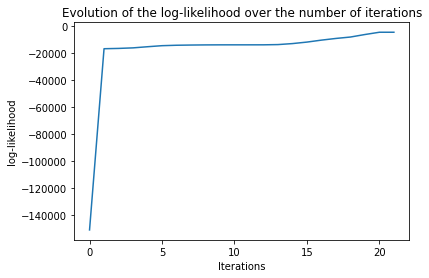

In [630]:
np.random.seed(0)
#We run the EM algorithm passing the previously generated points
d=2
p=p
x = np.array(samples)
alpha, mu, Sigma, log_likelihood_evolution = EM(d,p,n,x)

#plot the log-likelihood over the number of iterations of the algorithm
iterations = len(log_likelihood_evolution)
plt.plot(np.arange(iterations),log_likelihood_evolution)
plt.title("Evolution of the log-likelihood over the number of iterations")
plt.xlabel("Iterations")
plt.ylabel("log-likelihood")
plt.plot()

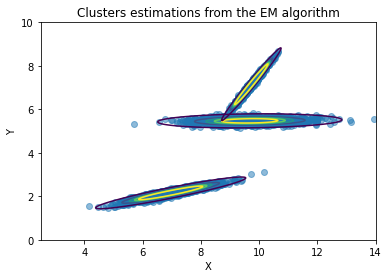

In [634]:
#Plot the distribution prediction


# Parameters for controlling the threshold and levels
threshold = 0.01  # Set your desired threshold here
levels = np.linspace(threshold, 1, 5)  # Adjust the number of levels as needed


N    = 1000
X    = np.linspace(2.5,14, N)
Y    = np.linspace(0, 10, N)
X, Y = np.meshgrid(X, Y)
pos  = np.dstack((X, Y))



# Create a figure and axis
fig, ax = plt.subplots()

ax.scatter(x_samples, y_samples, label='Generated Points', marker='o', alpha=0.5)

# Plot the contours for each Gaussian distribution with varying colors
for mean, cov in zip(mu, Sigma):
    rv = multivariate_normal(mean=mean, cov=cov)
    pdf_values = rv.pdf(pos)
    ax.contour(X, Y, pdf_values,levels=levels)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Clusters estimations from the EM algorithm')

plt.show()

In [645]:
print("Original paramter alpha : \n", alpha_exact)
print("Estimated paramter alpha : \n", alpha)

Original paramter alpha : 
 [0.33333333 0.33333333 0.33333333]
Estimated paramter alpha : 
 [0.3368     0.33263935 0.33056065]


In [644]:
print("Original paramter mu : \n", mu_exact)
print("Estimated paramter mu : \n", mu[[1,2,0],:])

Original paramter mu : 
 [[9.67029839 5.47232249]
 [9.7268436  7.14815994]
 [6.97728825 2.16089496]]
Estimated paramter mu : 
 [[9.67819848 5.4709881 ]
 [9.73068448 7.15462061]
 [6.96039157 2.15799463]]


In [648]:
print("Original paramter Sigma : \n", Sigma_exact)
print("Estimated paramter Sigma : \n", Sigma[[1,2,0],:,:])

Original paramter Sigma : 
 [[[0.96311181 0.01608244]
  [0.01608244 0.01003882]]

 [[0.07400008 0.11999459]
  [0.11999459 0.19904368]]

 [[0.61743774 0.16407237]
  [0.16407237 0.04907939]]]
Estimated paramter Sigma : 
 [[[0.9845779  0.01481484]
  [0.01481484 0.01021869]]

 [[0.07773249 0.12579044]
  [0.12579044 0.20821874]]

 [[0.58948381 0.15680466]
  [0.15680466 0.04717793]]]


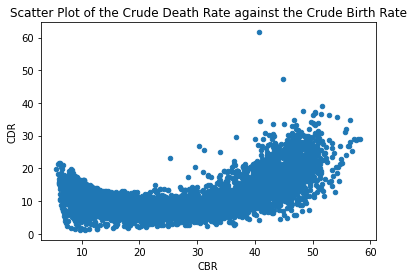

In [671]:
#Question 5 - Crude Birth/Death Rate

df = pd.read_csv("WPP2019_Period_Indicators_Medium.csv",header=0).dropna()

df = df[['CBR','CDR']]

# Create a scatter plot
df.plot.scatter(x='CBR', y='CDR')

plt.title('Scatter Plot of the Crude Death Rate against the Crude Birth Rate')

plt.show()


In [745]:
#Question 6
np.random.seed(100) 
x = df.values
n,d = x.shape
clusters_number = [2,3,5,7,9,10]


#We run the EM algorithm for multiple values of the number of cluster p

alphas =[]
mus = []
Sigmas = []

log_likelihood_final = []

for p in clusters_number:
    alpha, mu, Sigma, log_likelihood_evolution = EM(d,p,n,x,epsilon=0.01)
    alphas.append(alpha)
    mus.append(mu)
    Sigmas.append(Sigma)
    log_likelihood_final.append(log_likelihood_evolution[-1])



log_likelihood :  -inf
log_likelihood :  -978970.3980143077
log_likelihood :  -81139.84669815973
log_likelihood :  -80787.97934032617
log_likelihood :  -80545.55317218983
log_likelihood :  -80372.50840650231
log_likelihood :  -80244.53617485051
log_likelihood :  -80146.6359915436
log_likelihood :  -80068.51594450288
log_likelihood :  -80004.48658236736
log_likelihood :  -79952.04263144248
log_likelihood :  -79909.14726456307
log_likelihood :  -79873.83694310788
log_likelihood :  -79844.57809460316
log_likelihood :  -79820.30303573413
log_likelihood :  -79800.25816745425
log_likelihood :  -79783.83978235227
log_likelihood :  -79770.50920700902
log_likelihood :  -79759.77390188041
log_likelihood :  -79751.18927088704
log_likelihood :  -79744.36358670001
log_likelihood :  -79738.9608162001
log_likelihood :  -79734.6994288275
log_likelihood :  -79731.34779142341
log_likelihood :  -79728.71778561949
log_likelihood :  -79726.65803600042
log_likelihood :  -79725.04754969548
log_likelihood :  

Best number of clusters : 9


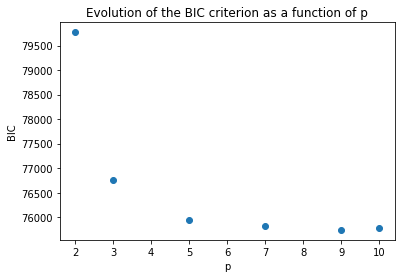

In [756]:
#Compute the BIC

def BIC(p,d,log_likelihood,n):
    df = p - 1 + p*d + p*d*(d+1)/2
    #print((df * np.log(n) / 2))
    return -log_likelihood + (df * np.log(n) / 2)


bics = []
for j in range(len(clusters_number)) : 
    bics.append(BIC(clusters_number[j],d,log_likelihood_final[j],n))

plt.scatter(clusters_number,bics)
plt.title("Evolution of the BIC criterion as a function of p")
plt.xlabel("p")
plt.ylabel("BIC")

print("Best number of clusters :",clusters_number[np.argmin(bics)])

Parameters estimation with p=2

alpha estimated : 

[0.3740831 0.6259169]
mu estimated : 

[[34.63221089 11.99278981]
 [12.91308048  9.93781104]]
Sigma estimated : 

[[[89.6659295  45.92331225]
  [45.92331225 39.80743602]]

 [[14.99229766 -7.74042347]
  [-7.74042347  7.24361379]]]
Parameters estimation with p=3

alpha estimated : 

[0.22371864 0.43269175 0.34358961]
mu estimated : 

[[40.9735291  15.19638897]
 [19.28250157  7.7001211 ]
 [10.26782654 11.56917845]]
Sigma estimated : 

[[[35.23366109 25.14161725]
  [25.14161725 38.54127257]]

 [[33.71958715 -2.59478123]
  [-2.59478123  3.38650542]]

 [[ 2.34195697 -2.424781  ]
  [-2.424781    4.80159879]]]
Parameters estimation with p=5

alpha estimated : 

[0.11562325 0.09826079 0.27052359 0.25634814 0.25924423]
mu estimated : 

[[44.83044276 19.15183855]
 [37.01328427 11.24070967]
 [14.05671477  8.99371252]
 [ 9.80037263 12.01472813]
 [22.76796608  7.23125229]]
Sigma estimated : 

[[[17.1093163   9.17965526]
  [ 9.17965526 32.57835374]]

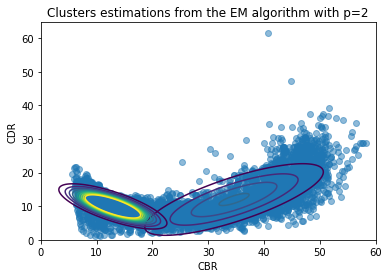

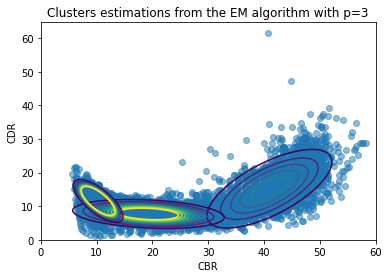

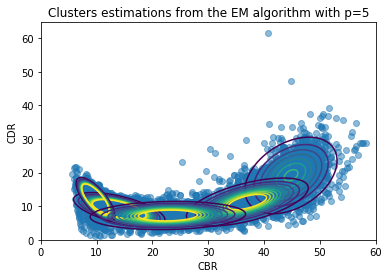

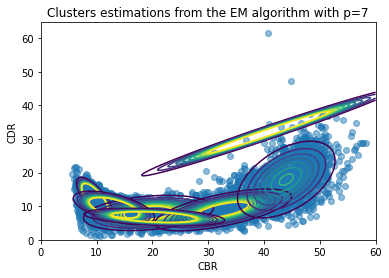

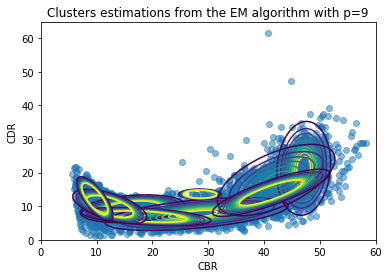

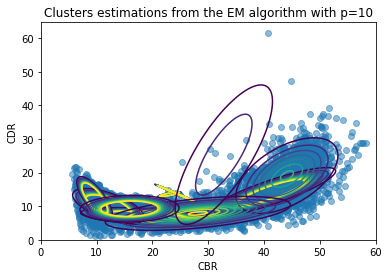

In [755]:
threshold = 0.01  # Set your desired threshold here
levels = np.linspace(0.001,threshold, 10)  # Adjust the number of levels as needed
N    = 1000
X    = np.linspace(0,60, N)
Y    = np.linspace(0, 60, N)
X, Y = np.meshgrid(X, Y)
pos  = np.dstack((X, Y))


for j in range(len(clusters_number)):
# Create a figure and axis
    fig, ax = plt.subplots()

    ax.scatter(x[:,0], x[:,1], marker='o', alpha=0.5)
    
    # Plot the contours for each Gaussian distribution with varying colors
    for mean, cov in zip(mus[j], Sigmas[j]):
        rv = multivariate_normal(mean=mean, cov=cov)
        pdf_values = rv.pdf(pos)
        ax.contour(X, Y, pdf_values,levels=levels)

        ax.set_xlabel('CBR')
        ax.set_ylabel('CDR')
        ax.set_title(f'Clusters estimations from the EM algorithm with p={clusters_number[j]}')
    
   
    print(f"Parameters estimation with p={clusters_number[j]}\n")
    print("alpha estimated : \n")
    print(alphas[j])
    print("mu estimated : \n")
    print(mus[j])
    print("Sigma estimated : \n")
    print(Sigmas[j])


Exercise 3: Importance sampling

3.A - Poor Importance Sampling


C:\Users\yokoz\AppData\Local\Temp/ipykernel_27244/2415601889.py:15: RuntimeWarning: invalid value encountered in power
  w = np.where(x<0,0,(np.sqrt(3*np.pi)/2) * (x**(0.65)) * np.exp(-(x**2 + 3.2*x -1.28)/6))


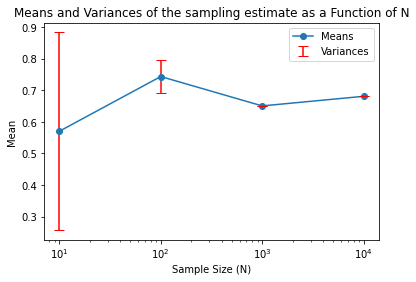

There is convergence towards the value 0.6808120215728378 with variance 0.00023253944273687955


In [64]:
#Question 1 2 - Simple Importance Sampling procedure
np.random.seed(100)

def f(x):
    f = 2*np.sin(2*np.pi*x / 3)
    f = np.where(x<0,0,f)
    return f

N = 50000
mean_q = 0.8
var_q = 1.5

#Compute the importance weights
def weights(x):
    w = np.where(x<0,0,(np.sqrt(3*np.pi)/2) * (x**(0.65)) * np.exp(-(x**2 + 3.2*x -1.28)/6))
    return w

#Compute the normalized importance weights as p is only known up to a constant
def normalized_weights(w,N):
    m = np.sum(w) / N
    return w / m


#Draw N samples from the distribution q
def draw_q(N,R,mean_q,var_q):
    samples = np.random.normal(mean_q, var_q, N*R)
    return samples


def estimate_mean_variance(mean_q,var_q):

    N_sizes = np.array([10,100,1000,10000])
    R = 10

    means = []
    variances = []

    for N in N_sizes:
        #To compute the mean and the variance of the sampling estimate, we run R times the procedure with same N size
        s = draw_q(N,R,mean_q,var_q)
        w = weights(s)
        f_value = f(s)
        w = w.reshape((R,N))
        f_value = f_value.reshape((R,N))
        w_tilde = np.apply_along_axis(normalized_weights, axis=1, arr=w,N=N)  
        estimators = np.sum(w_tilde * f_value,axis=1) / N
        mean_estimator = np.mean(estimators)
        means.append(mean_estimator)
        var_estimator = np.var(estimators)
        variances.append(var_estimator)

    plt.plot(N_sizes,means,label='Means', marker='o')

    # Plotting the variances as error bars
    plt.errorbar(N_sizes, means, yerr=variances, fmt='none', ecolor='red', capsize=5, label='Variances')

    # Set x-axis to log scale
    plt.xscale('log')

    # Adding labels and title
    plt.xlabel('Sample Size (N)')
    plt.ylabel('Mean')
    plt.title('Means and Variances of the sampling estimate as a Function of N')

    # Adding legend
    plt.legend()

    # Display the plot
    plt.show()

    print(f"There is convergence towards the value {means[-1]} with variance {variances[-1]}")

    return means, variances, w_tilde

means_08, variances_08, w_tilde_08 = estimate_mean_variance(mean_q,var_q)

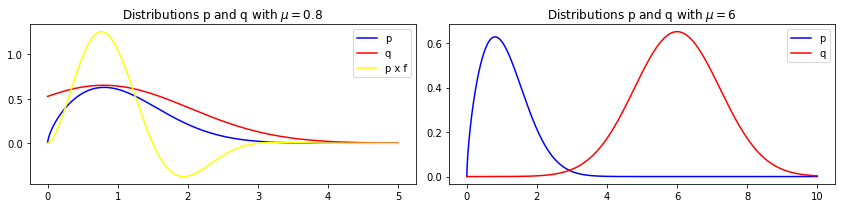

In [61]:
#Question 3 - Shift the mean


def p(x):
    return np.where(x<0,0,x**(0.65) * np.exp(-(x**2)/2))

def q(x,mean_q):
    return (2 / np.sqrt(2*np.pi*1.5)) * np.exp( -  ((x - mean_q)**2)  / 3  )


# Create subplots with wider width
fig, axes = plt.subplots(1, 2, figsize=(12, 3))  # Adjust the width as needed



x = np.linspace(0,5,1000)
axes[0].plot(x,p(x),c='blue',label='p')
axes[0].plot(x,q(x,0.8),c='red',label='q')
axes[0].plot(x,p(x)*f(x),c='yellow',label='p x f')

axes[0].legend()

axes[0].set_title(r'Distributions p and q with $\mu = 0.8$')


x = np.linspace(0,10,1000)
axes[1].plot(x,p(x),c='blue',label='p')
axes[1].plot(x,q(x,6),c='red',label='q')

axes[1].legend()

axes[1].set_title(r'Distributions p and q with $\mu = 6$')

plt.tight_layout()
plt.show()

C:\Users\yokoz\AppData\Local\Temp/ipykernel_27244/2415601889.py:15: RuntimeWarning: invalid value encountered in power
  w = np.where(x<0,0,(np.sqrt(3*np.pi)/2) * (x**(0.65)) * np.exp(-(x**2 + 3.2*x -1.28)/6))


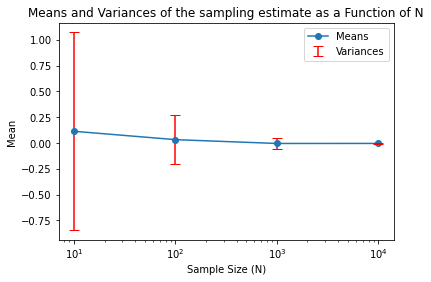

There is convergence towards the value -0.004520785662545187 with variance 0.0015401412651847033


In [103]:
np.random.seed(0)
mean_q = 6
means_6, variances_6, w_tilde_6 = estimate_mean_variance(mean_q,var_q)

In [109]:
print(f"Normalized importance weights metrics for mu=0.8 and for N=10000 \n")
w_tildes_08 = w_tilde_08[1,:].flatten()
print("Mean : ",np.mean(w_tildes_08))
print("Variance : ",np.var(w_tildes_08))
print("1st Quantile : ",np.percentile(w_tildes_08, 25))
print("Median : ",np.median(w_tildes_08))
print("3rd Quantile : ",np.percentile(w_tildes_08,75))


print(f"\n\nNormalized importance weights metrics for mu=6 and for N=10000 \n")
w_tildes_6 = w_tilde_6[1,:].flatten()
print("Mean : ",np.mean(w_tildes_6))
print("Variance : ",np.var(w_tildes_6))
print("1st Quantile : ",np.percentile(w_tildes_6, 25))
print("Median : ",np.median(w_tildes_6))
print("3rd Quantile : ",np.percentile(w_tildes_6,75))




Normalized importance weights metrics for mu=0.8 and for N=10000 

Mean :  1.0000000000000002
Variance :  0.7448347447448481
1st Quantile :  0.0
Median :  0.9874827254991875
3rd Quantile :  1.8936084560613955


Normalized importance weights metrics for mu=6 and for N=10000 

Mean :  1.0
Variance :  14.724238098461251
1st Quantile :  0.0025897915140211123
Median :  0.034770452962260424
3rd Quantile :  0.3355912150775743


3.C – Application to a "banana"-shaped density

In [410]:
#Question 5


#We modify slightly our EM algorithm so that we take into account the modification in the parameter updates

def EM_AIS(d,p,n,x,wi,epsilon=0.001) :

    #Initialization of the parameters alpha, mu and sigma for each cluster

    alpha = np.random.rand(p)
    alpha /= np.sum(alpha)

    #We take the mean of the samples
    mean_samples = np.mean(x,axis=0)

    
    #For each cluster, we generate randomly the parameters of each gaussian distribution
    #based on the mean of the samples
    mu = mean_samples + (np.random.rand(p,d))

    Sigma = np.array([np.eye(d)] * p)

    #Sigma = np.zeros((p,d,d))
    # for k in range(p):
    #     V = np.random.rand(d,1)
    #     sigma_k = (V @ V.T) + 0.01
    #     #To be sure to obtain a symmetric definite positive matrix for the covariance matrix
    #     Sigma[k] = sigma_k
    
    #EM iterations steps
    AIS_log_likelihood_evolution = []
    AIS_log_likelihood = -np.inf

    #print("####################START####################")

    while True:
    
        #print("AiS_log_likelihood : ",AIS_log_likelihood)
        #E step : One compute/update the tau_ij

        #We get the value of the pdf of each multivariate gaussian at each sample x_i
        logpdf_gaussian = np.zeros((p,n))

        

        for j in range(p):

            # # Compute eigenvalues
            # eigenvalues = np.linalg.eigvals(Sigma[j])
            # # if np.sum(eigenvalues)==0:
            # #     print(Sigma[j])
            # print(np.sum(eigenvalues))

            # det_A = np.linalg.det(Sigma[j])
            # print(det_A)

            logpdf_gaussian[j] = multivariate_normal.logpdf(x, mean=mu[j], cov=Sigma[j])#,allow_singular=True)

        #Term for the numerator  
        a_k = logpdf_gaussian + np.log(alpha[:, np.newaxis])
        A = np.max(a_k,axis=0)

        #For the denominator, we use the log sum exp trick
        logdenom = A + np.log(np.sum(np.exp(a_k - A),axis=0))


        tau_ij = np.exp(a_k - logdenom)

        #We check the evolution of the data log-likelihood. Quit the loop if the change is smaller than epsilon
        if abs(np.sum(wi*logdenom) - AIS_log_likelihood) < epsilon:
            AIS_log_likelihood = np.sum(wi*logdenom)
            AIS_log_likelihood_evolution.append(AIS_log_likelihood)
            break

        AIS_log_likelihood = np.sum(wi*logdenom)
        AIS_log_likelihood_evolution.append(AIS_log_likelihood)
        #M step : One update the parameters theta
        posterior_j = np.sum(tau_ij*wi,axis=1) + 1e-40

        #alpha
        alpha = posterior_j / n

        #mu 
        mu = ((tau_ij*wi) @ x) / posterior_j[:, np.newaxis]
        

        #Sigma
        for j in range(p):
            estimator_matrices = np.zeros((n,d,d))
            for i in range(n):
                estimator_matrices[i] = ((x[i]-mu[j]).reshape(-1,1))@((x[i]-mu[j]).reshape(1,-1))*tau_ij[j,i]*wi[i] + np.diag(np.ones(d))*1e-10
            
            Sigma[j] = (np.sum( estimator_matrices,axis=0) /  posterior_j[j]) 
            
            


    return alpha, mu, Sigma, AIS_log_likelihood_evolution


In [407]:
def sample_gaussian_mixture(p,n,alpha,mu,Sigma):
    cluster = np.random.choice(p,n,replace=True,p=alpha)
    samples = []
    for mean, cov in zip(mu[cluster], Sigma[cluster]):
        mvn = multivariate_normal(mean=mean, cov=cov)
        point = mvn.rvs()
        samples.append(point)
    return np.array(samples)

In [408]:
def compute_wi_tilde(n,x,p,b,sigma_1_square,alpha,mu,Sigma):

    #We get the value of the pdf of each multivariate gaussian at each sample x_i
    logpdf_gaussian = np.zeros((p,n))
    for j in range(p):
        logpdf_gaussian[j] = multivariate_normal.logpdf(x, mean=mu[j], cov=Sigma[j])#,allow_singular=True)

    #Term for the numerator  
    a_k = logpdf_gaussian + np.log(alpha[:, np.newaxis])
    A = np.max(a_k,axis=0)

    #For the denominator, we use the log sum exp trick
    logdenom = A + np.log(np.sum(np.exp(a_k - A),axis=0))

    x_nu = x.copy()

    x_nu[:,1] = x_nu[:,1] + b*(x_nu[:,0]**2 - sigma_1_square)

    log_nu = np.zeros(n)

    Sigma_nu = np.eye(d)
    Sigma_nu[0,0] = sigma_1_square

    log_nu = multivariate_normal.logpdf(x_nu, mean=np.zeros(d), cov=Sigma_nu)#,allow_singular=True)

    log_w = log_nu - logdenom

    #Compute the normalized importance weights

    B = np.max(log_w)

    log_w_tilde = log_w + np.log(n) - B - np.log(np.sum(np.exp(log_w - B)))

    w_tilde = np.exp(log_w_tilde)

    return w_tilde



    

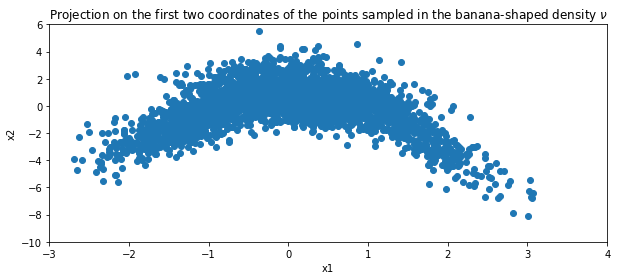

In [414]:
#Population Monte Carlo Algorithm
np.random.seed(1)
d=5
sigma_1_square = 1
b = 1


p = 3

#Initialization : choice of theta_0
alpha = np.ones(p) / p
mu = np.random.rand(p,d)
Sigma = np.array([np.eye(d)] * p)

n = 3000

for iter in range(40):
    x = sample_gaussian_mixture(p,n,alpha,mu,Sigma)
    wi_tilde = compute_wi_tilde(n,x,p,b,sigma_1_square,alpha,mu,Sigma)
    

    alpha, mu, Sigma, AIS_log_likelihood_evolution = EM_AIS(d,p,n,x,wi_tilde,epsilon=0.01)
   


final_x = sample_gaussian_mixture(p,n,alpha,mu,Sigma)

# Create subplots with wider width
fig, axes = plt.subplots(1, 1, figsize=(10, 4) ) # Adjust the width as needed

plt.scatter(x[:,0],x[:,1])
plt.xlim(-3,4)
plt.ylim(-10,6)
plt.title(r"Projection on the first two coordinates of the points sampled in the banana-shaped density $\nu$")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

